# Segmentation

In [1]:
import sys, os
sys.path.append('../')

import tensorflow as tf 

from MRIsegm.metrics import dice_coef
from MRIsegm.losses import DiceBCEloss
from MRIsegm.models import unet
from MRIsegm.methods import create_segmentation_generator_train, create_segmentation_generator_test, show_dataset, plot_history, show_prediction

## Constants

In [2]:
SEED = 13
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_VALIDATION = 4

IMAGE_HEIGHT = 128
IMAGE_WIDTH =  128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

NUM_OF_EPOCHS = 100

NUM_TRAIN = 424
NUM_VALIDATION = 45

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_VALIDATION = NUM_VALIDATION // BATCH_SIZE_VALIDATION

data_dir_training = '../data/training'
data_dir_train_img = os.path.join(data_dir_training, 'img')
data_dir_train_mask = os.path.join(data_dir_training, 'mask')

data_dir_validation = '../data/validation'
data_dir_validation_img = os.path.join(data_dir_validation, 'img')
data_dir_validation_mask = os.path.join(data_dir_validation, 'mask')

data_dir_test = '../data/test'
data_dir_test_img = os.path.join(data_dir_test, 'img')
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

## Generators

In [3]:
train_generator = create_segmentation_generator_train(data_dir_train_img, data_dir_train_mask, BATCH_SIZE_TRAIN, IMG_SIZE, SEED)

validation_generator = create_segmentation_generator_test(data_dir_validation_img, data_dir_validation_mask, BATCH_SIZE_VALIDATION, IMG_SIZE, SEED)

Found 424 images belonging to 1 classes.
Found 424 images belonging to 1 classes.
Found 45 images belonging to 1 classes.
Found 45 images belonging to 1 classes.


### Show trainig data

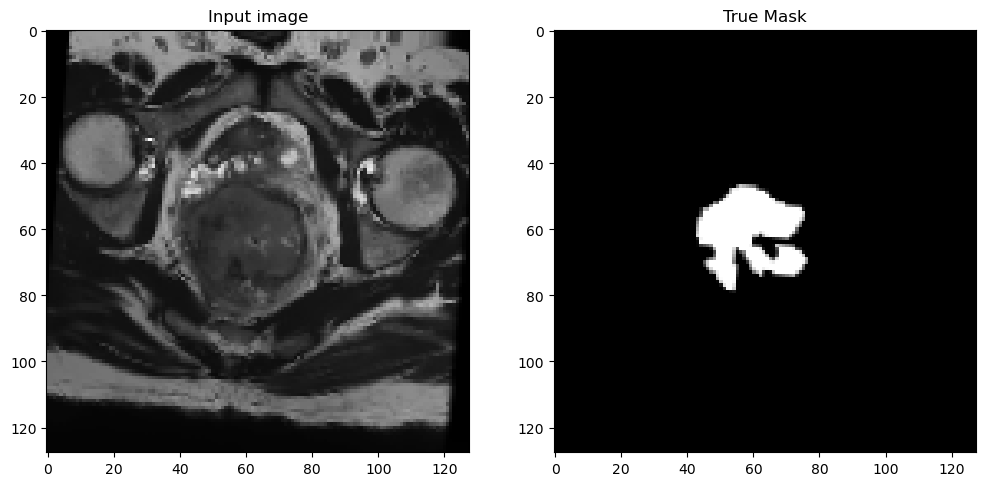

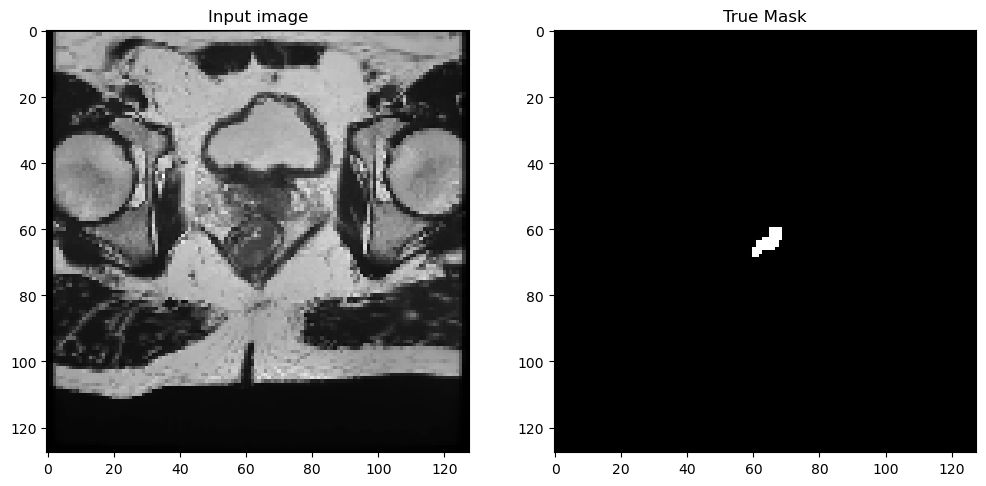

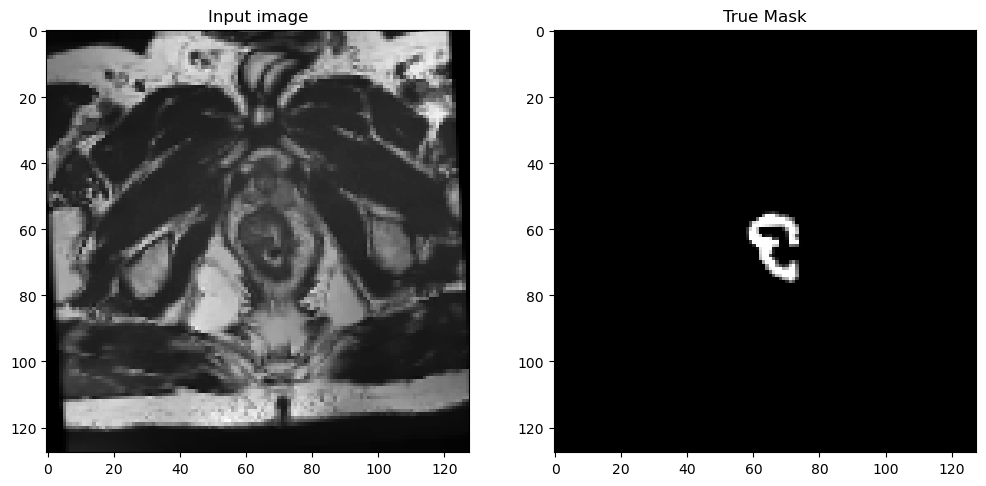

In [4]:
show_dataset(train_generator, 3) # training

### Show test data

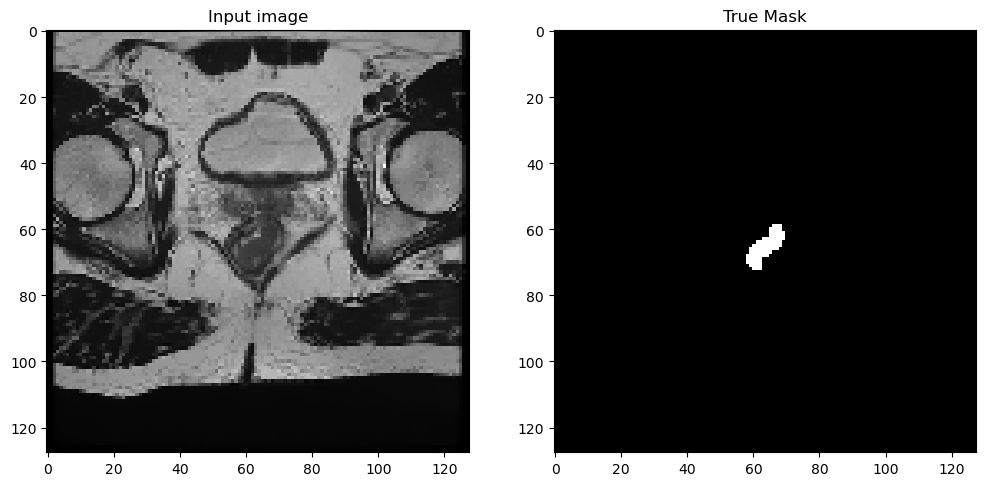

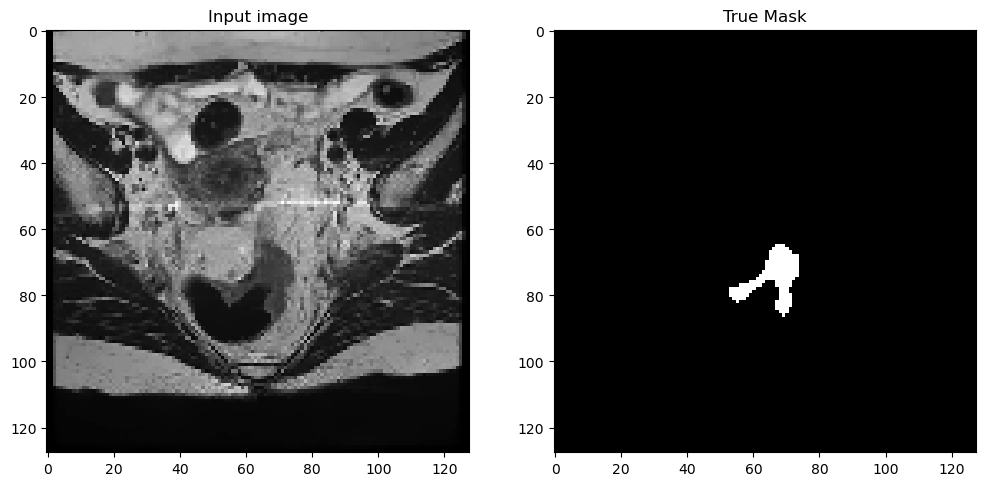

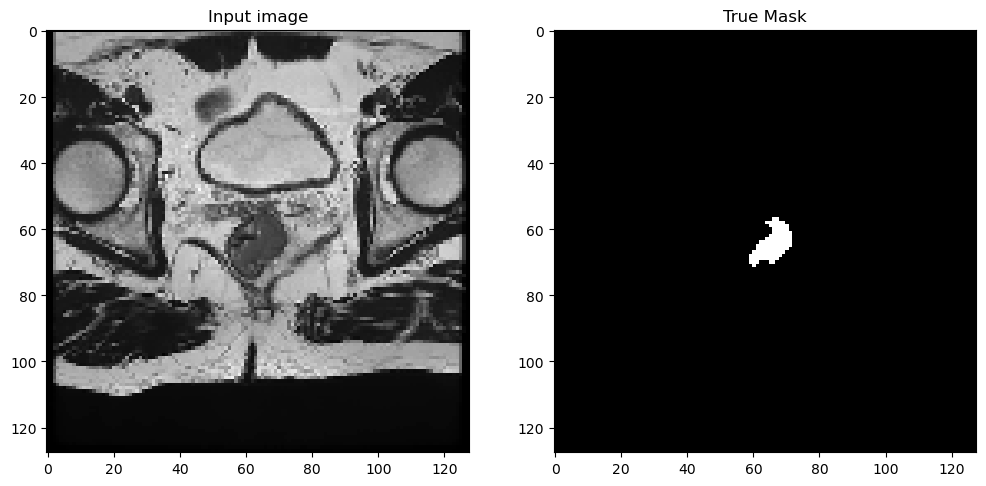

In [5]:
show_dataset(validation_generator, 3) # validation

## U-Net Model

In [6]:
model = unet(IMAGE_HEIGHT, IMAGE_WIDTH)

optimizer = 'adam'
loss = DiceBCEloss
metrics = [  dice_coef ]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "UNET-L4-F64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [7]:
model_name = model.name + f'_{IMAGE_HEIGHT}_{IMAGE_WIDTH}_opt={optimizer}' 

if type(loss) == str: 
    model_name = model_name + f'_loss={loss}' 
else:
    model_name = model_name + f'_loss={loss.__name__}'

print(model_name)

UNET-L4-F64_128_128_opt=adam_loss=DiceBCEloss


In [8]:
# optional: logs_dir = '../data/models/logs/model_name'

callbacks = [
                  tf.keras.callbacks.ModelCheckpoint('../data/models/checkpoints/' + model_name + '_checkpoint' + '.h5', save_best_only=True),
                  tf.keras.callbacks.EarlyStopping(patience=11, monitor='val_loss', mode='min')
                  # optional: tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
]

history = model.fit(train_generator,
            steps_per_epoch=EPOCH_STEP_TRAIN, 
            validation_data=validation_generator, 
            validation_steps=EPOCH_STEP_VALIDATION,
            epochs=NUM_OF_EPOCHS,
            callbacks=callbacks)

Epoch 1/100
106/106 [==============================] - 88s 821ms/step - loss: 0.2219 - dice_coef: 0.0142 - val_loss: 0.0860 - val_dice_coef: 0.0188
Epoch 2/100
106/106 [==============================] - 88s 834ms/step - loss: 0.0587 - dice_coef: 0.0259 - val_loss: 0.0648 - val_dice_coef: 0.0596
Epoch 3/100
106/106 [==============================] - 88s 828ms/step - loss: 0.0486 - dice_coef: 0.0514 - val_loss: 0.0642 - val_dice_coef: 0.0516
Epoch 4/100
106/106 [==============================] - 87s 821ms/step - loss: 0.0445 - dice_coef: 0.0517 - val_loss: 0.0623 - val_dice_coef: 0.0611
Epoch 5/100
106/106 [==============================] - 87s 819ms/step - loss: 0.0385 - dice_coef: 0.0738 - val_loss: 0.0591 - val_dice_coef: 0.0929
Epoch 6/100
106/106 [==============================] - 86s 814ms/step - loss: 0.0471 - dice_coef: 0.0678 - val_loss: 0.0527 - val_dice_coef: 0.1039
Epoch 7/100
106/106 [==============================] - 86s 813ms/step - loss: 0.0434 - dice_coef: 0.0941 - val_l

In [9]:
model.save('../data/models/' + model_name + '.h5')

In [10]:
# optional: %load_ext tensorboard

# optional: !tensorboard --logdir log_dir

## Plots

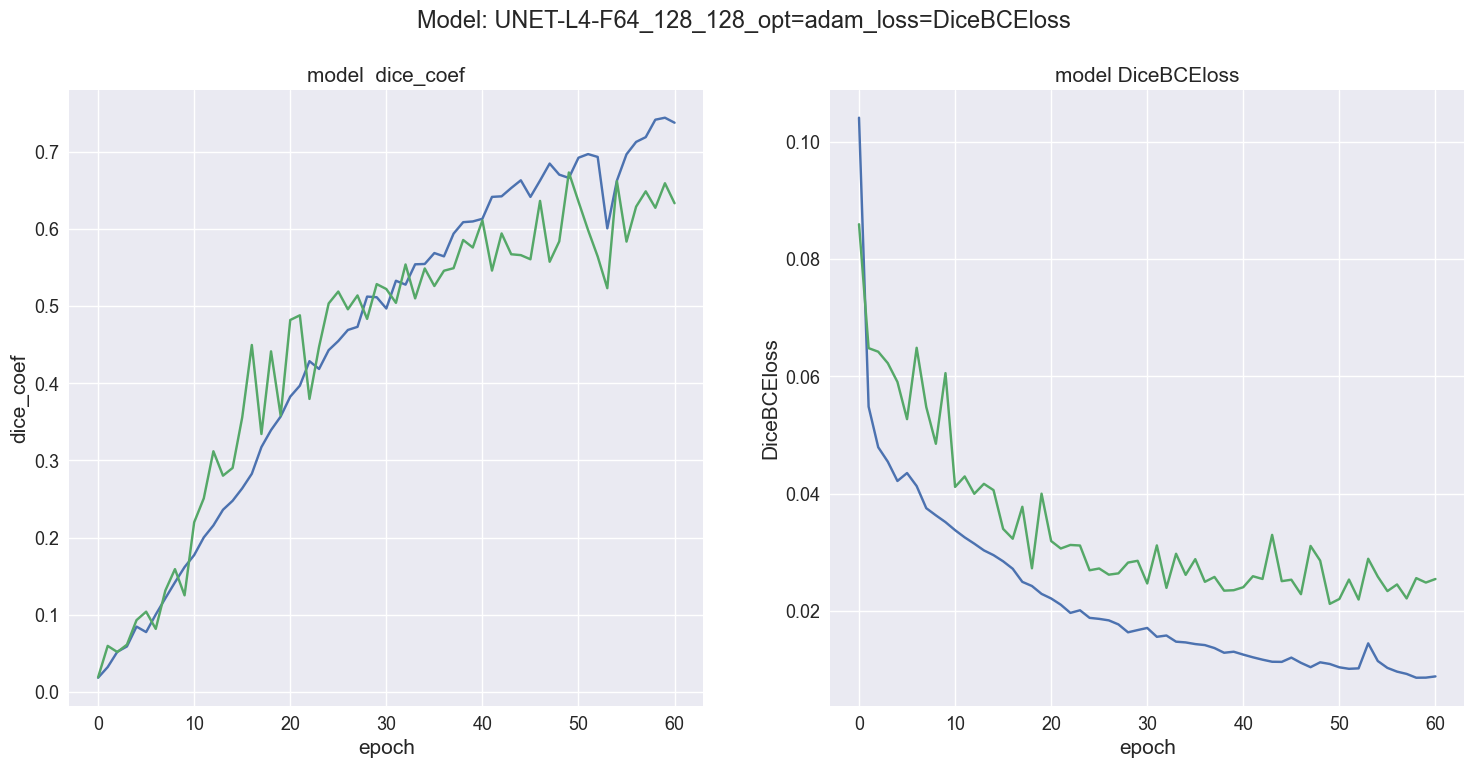

In [11]:
plot_history(model_name, history, metrics, loss, custom_loss=True, custom_metrics=True, labelsize=13, path='../data/plots/' + model_name)

## Predictions

### Validation images prediction

Found 45 images belonging to 1 classes.
Found 45 images belonging to 1 classes.


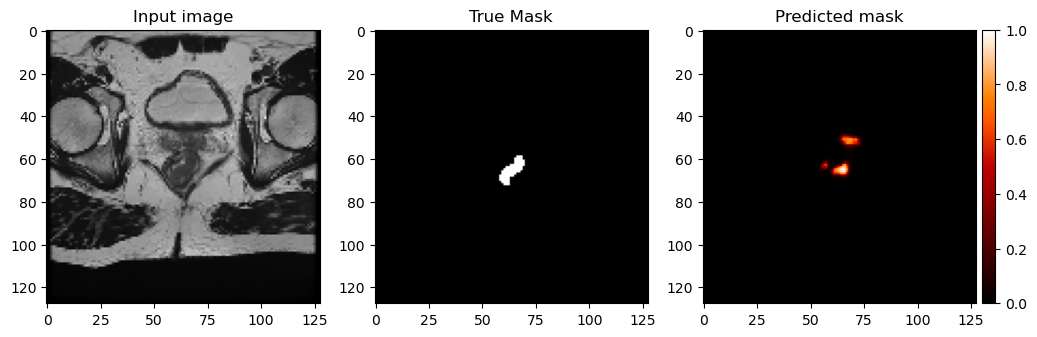

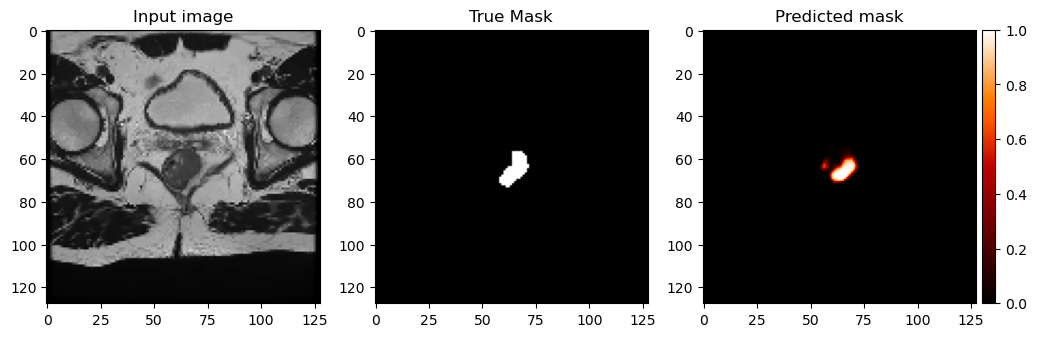

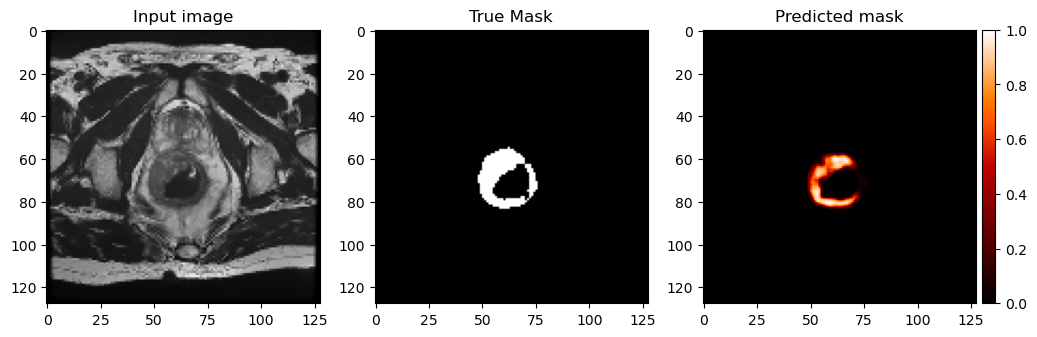

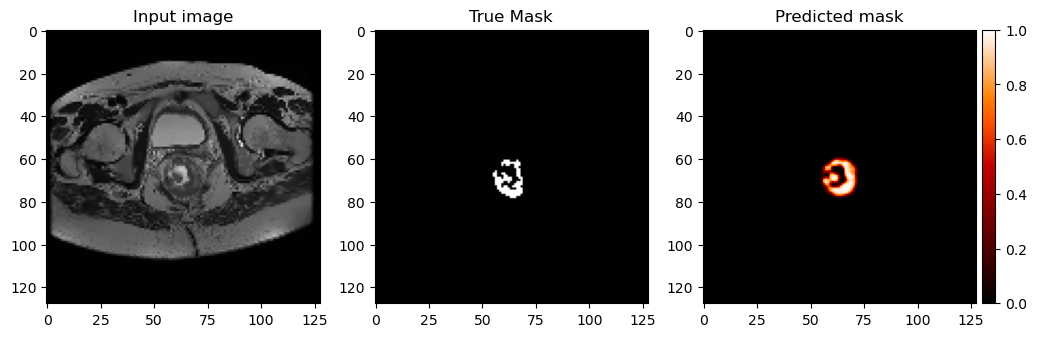

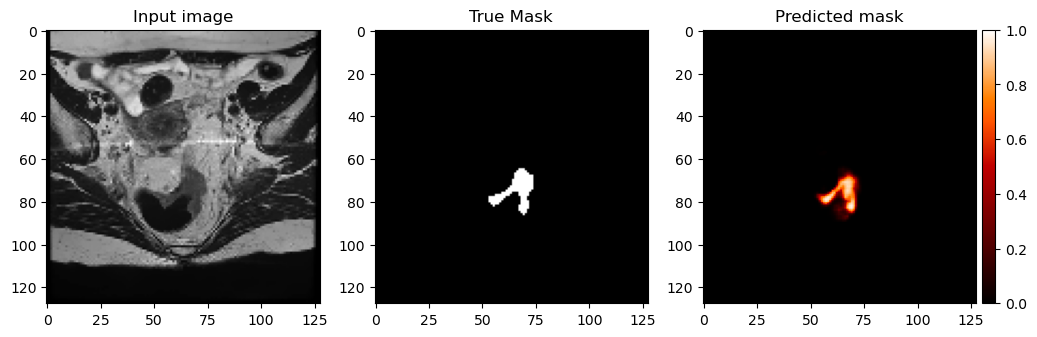

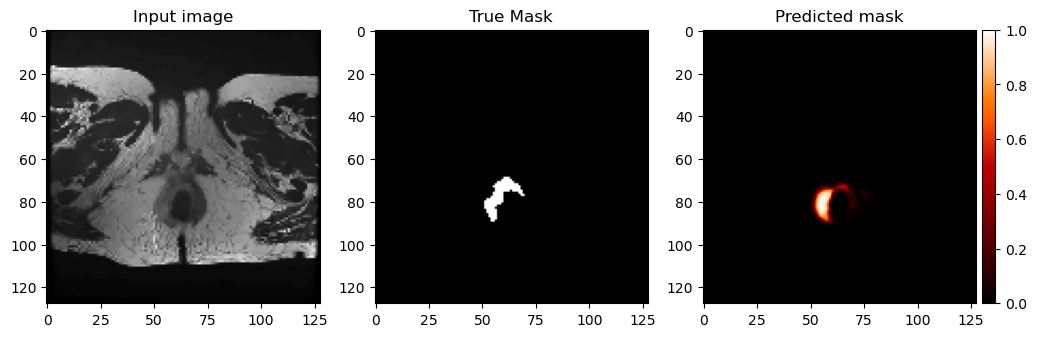

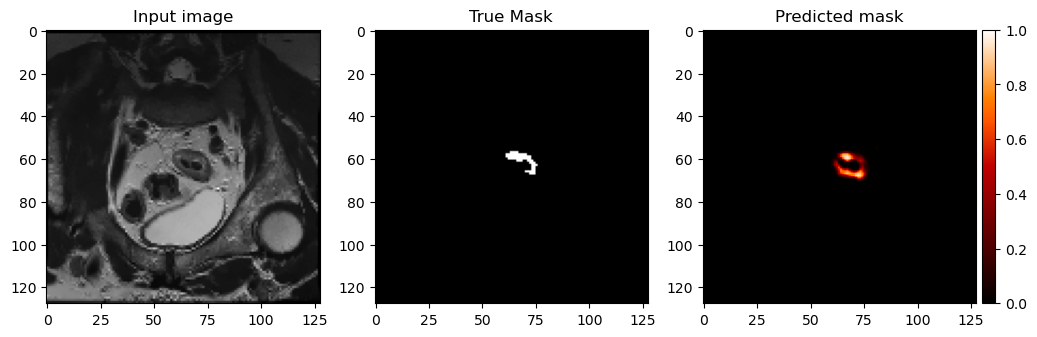

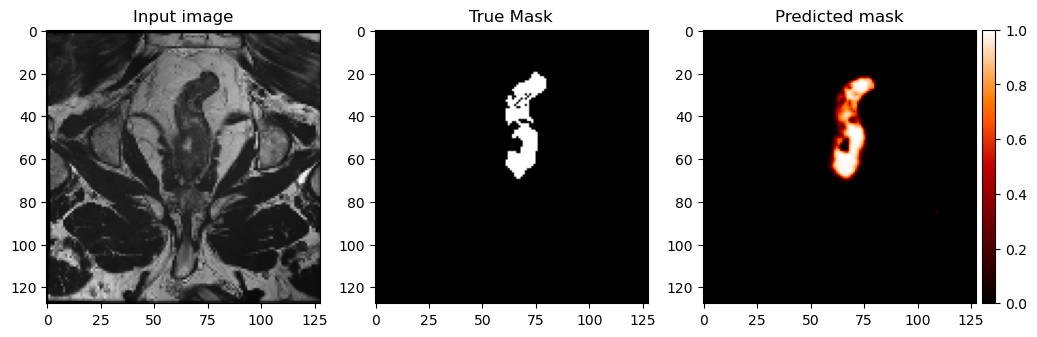

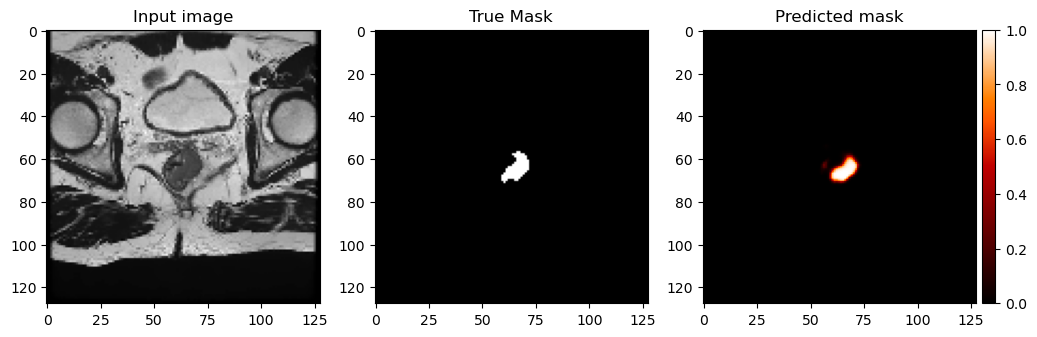

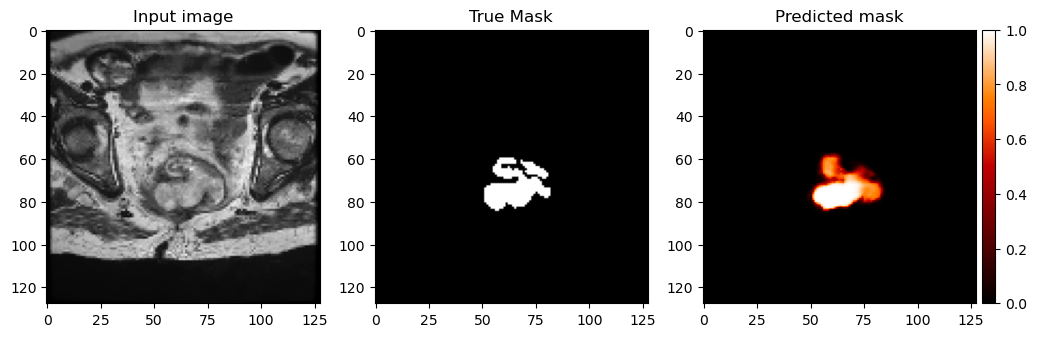

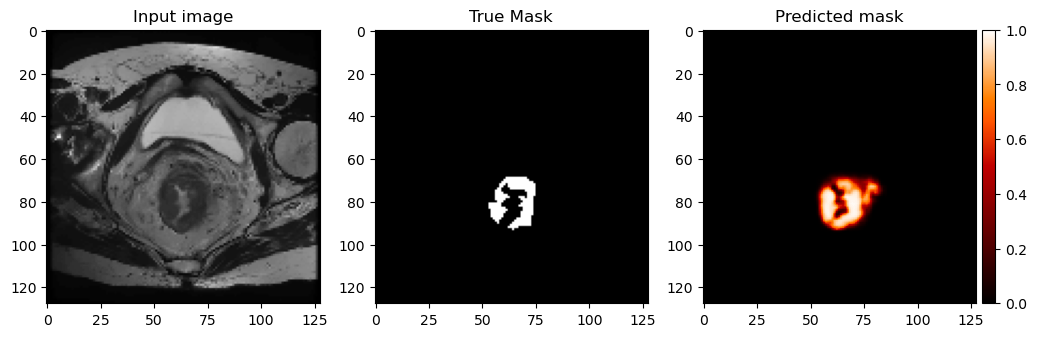

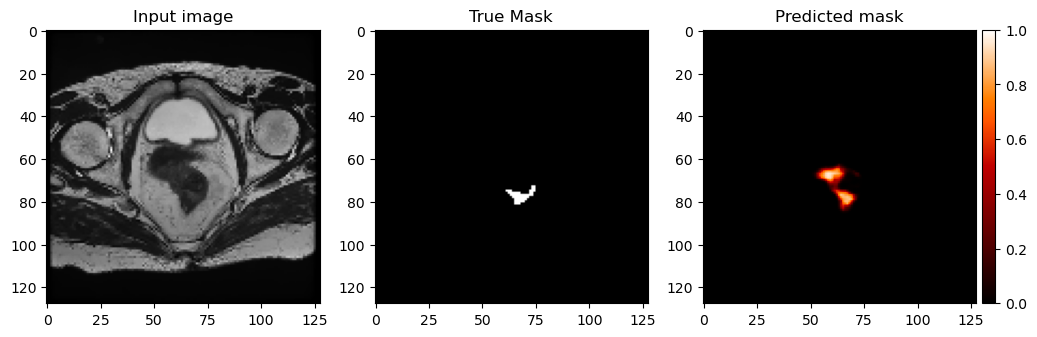

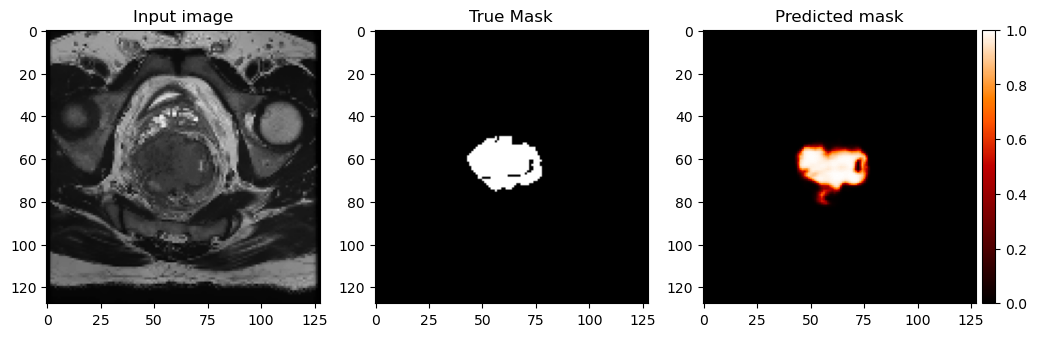

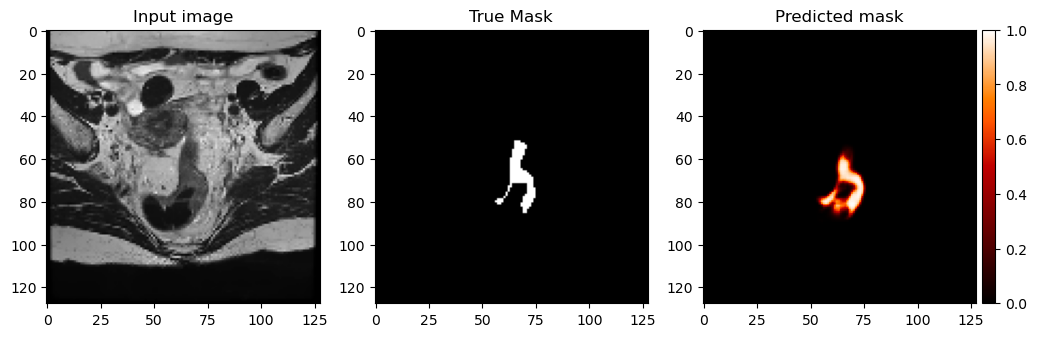

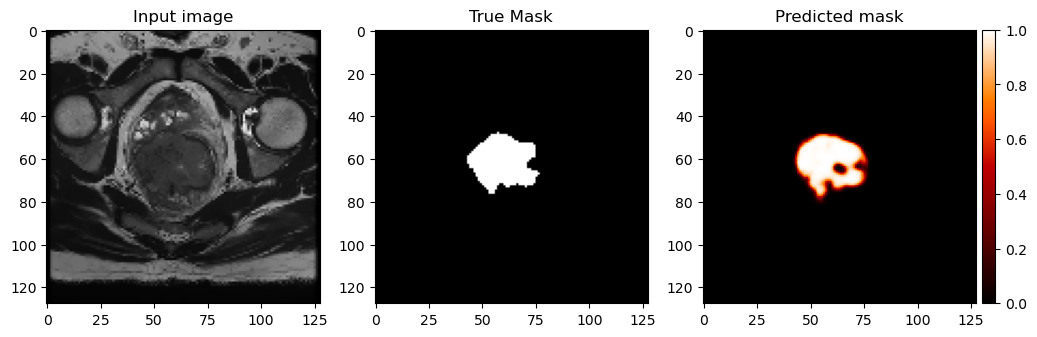

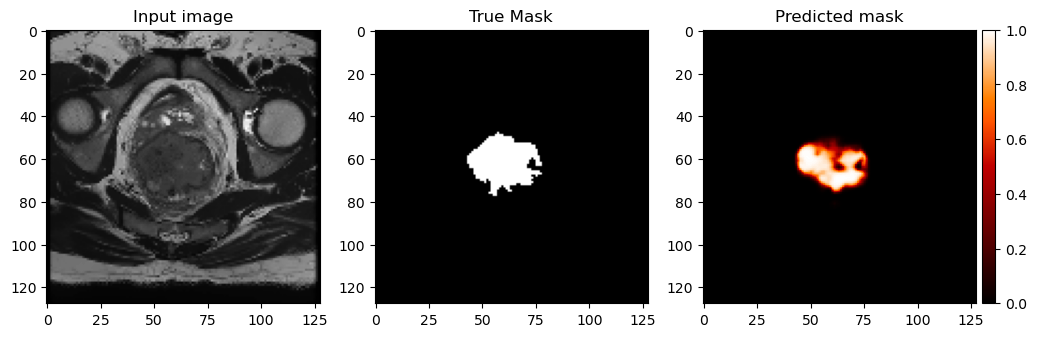

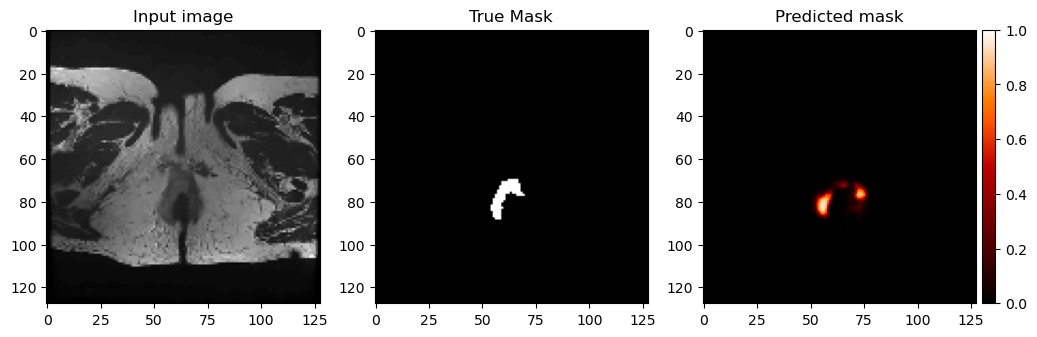

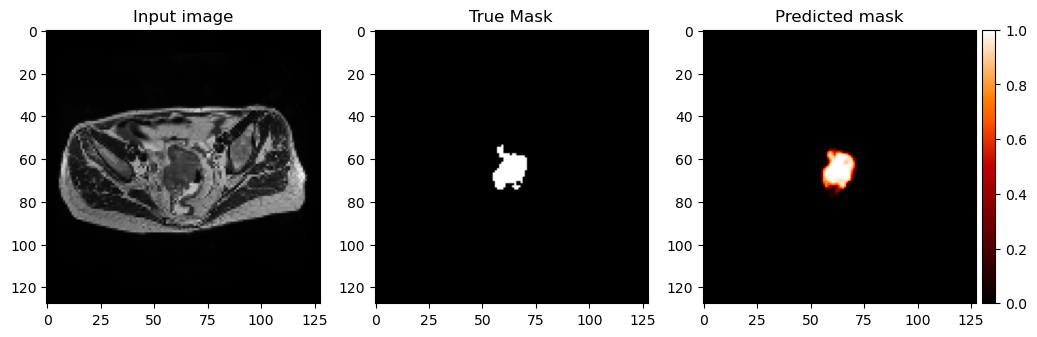

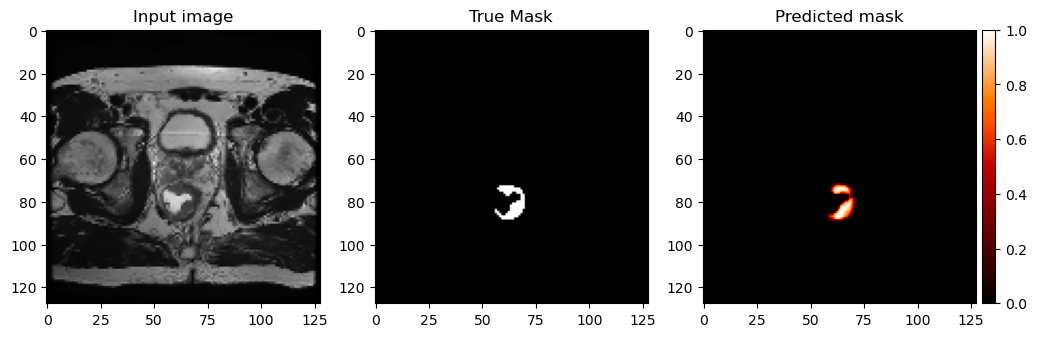

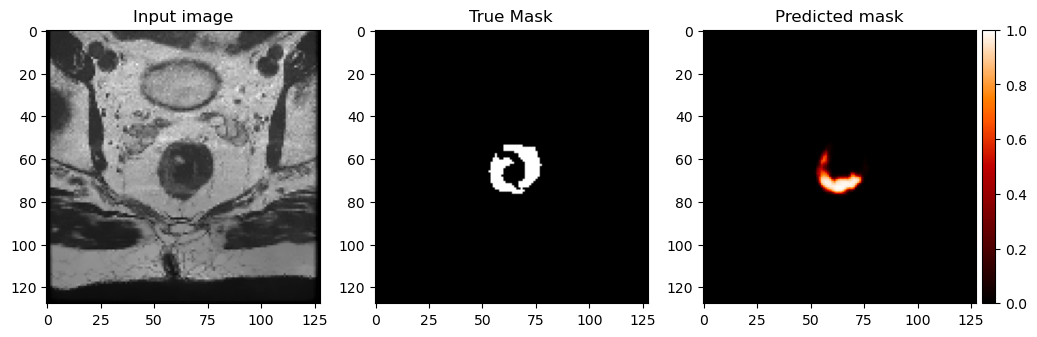

In [12]:

validation_generator = create_segmentation_generator_test(data_dir_validation_img, data_dir_validation_mask, 1, IMG_SIZE, SEED)

show_prediction(validation_generator, model ,20)

### Test images prediction

Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.


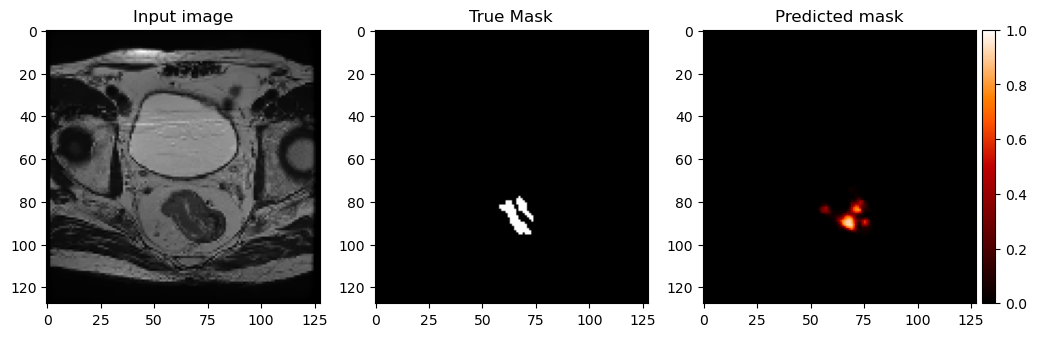

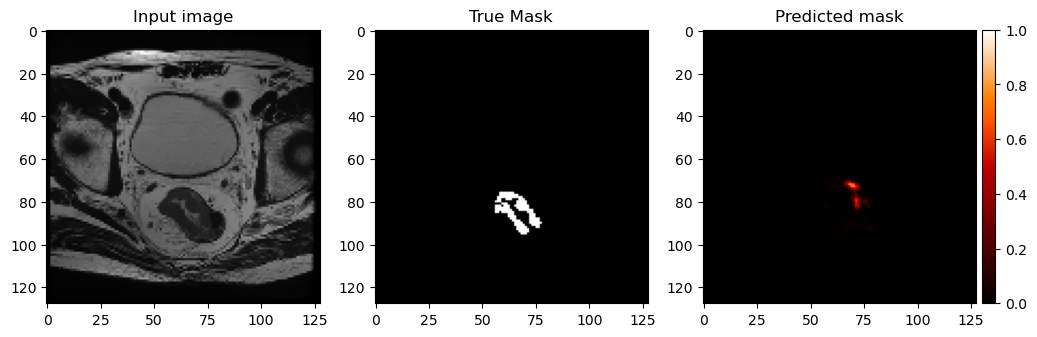

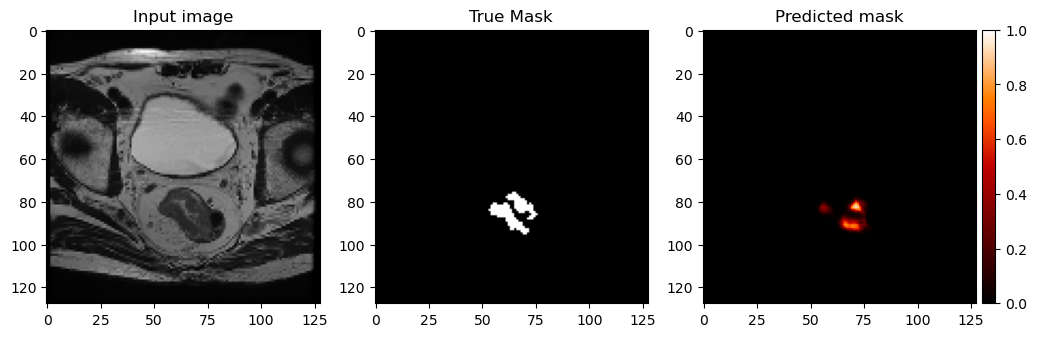

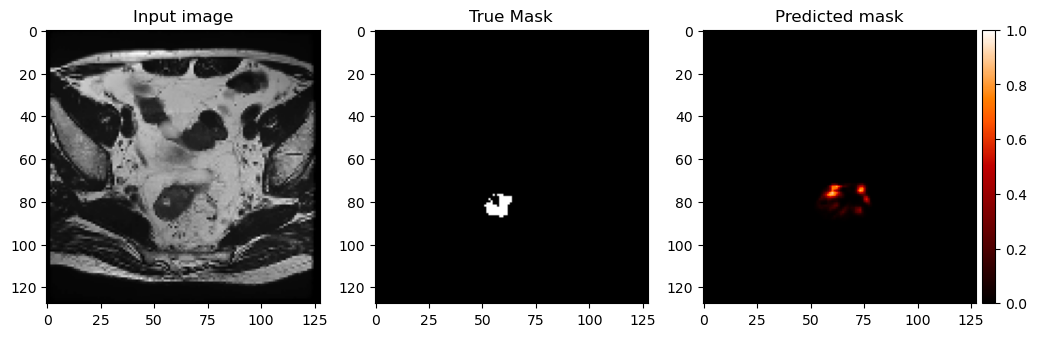

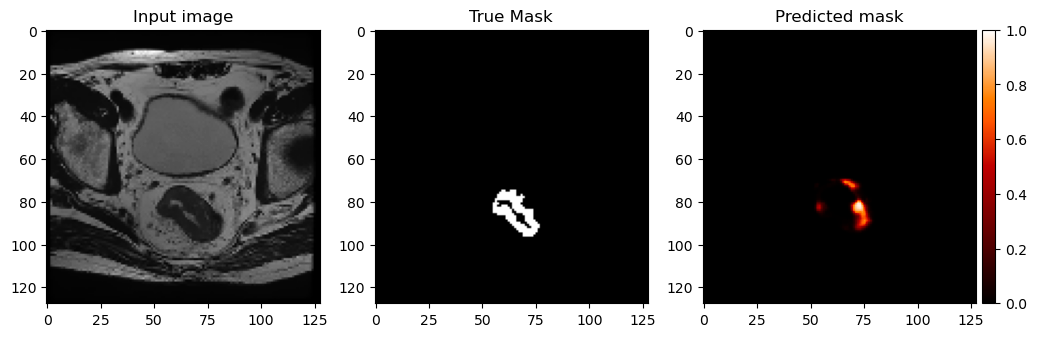

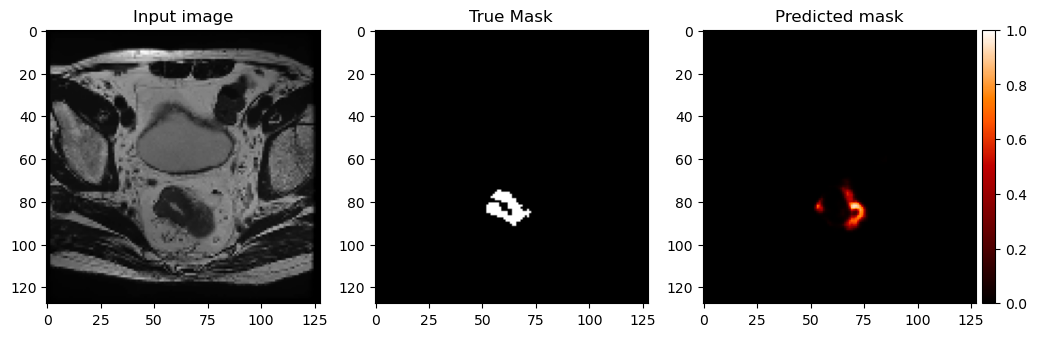

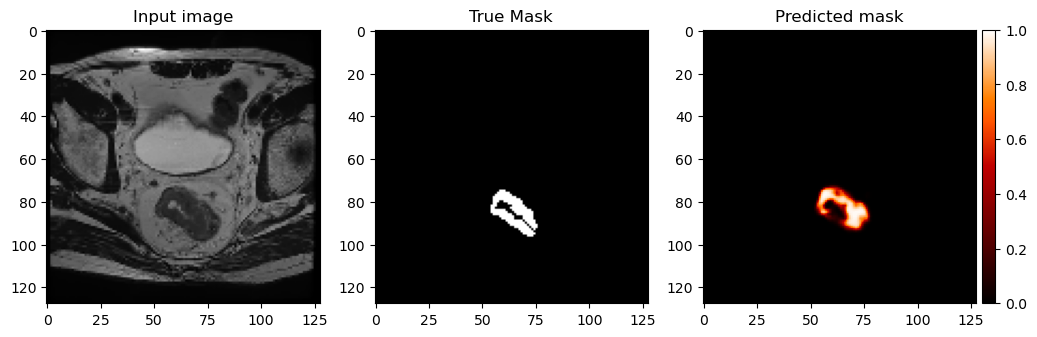

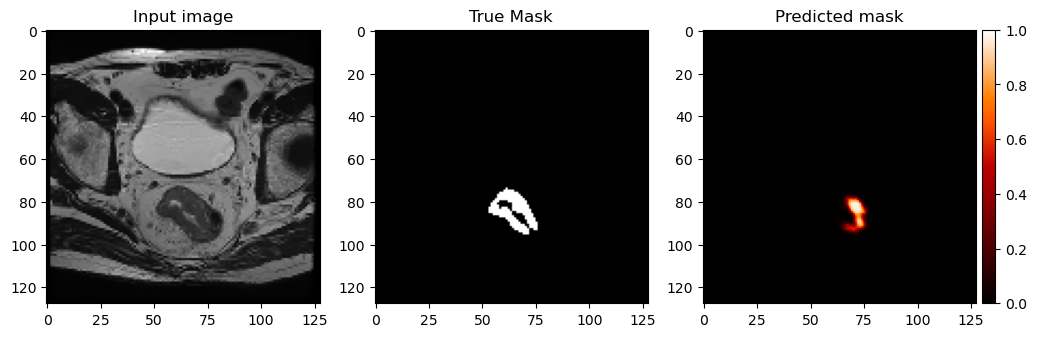

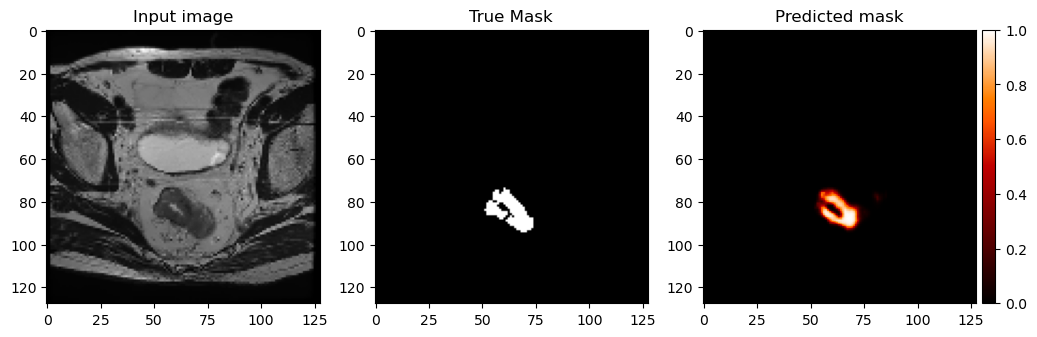

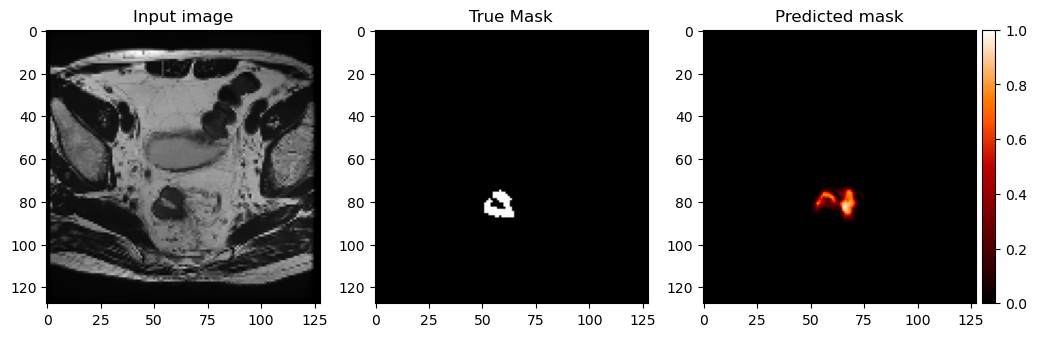

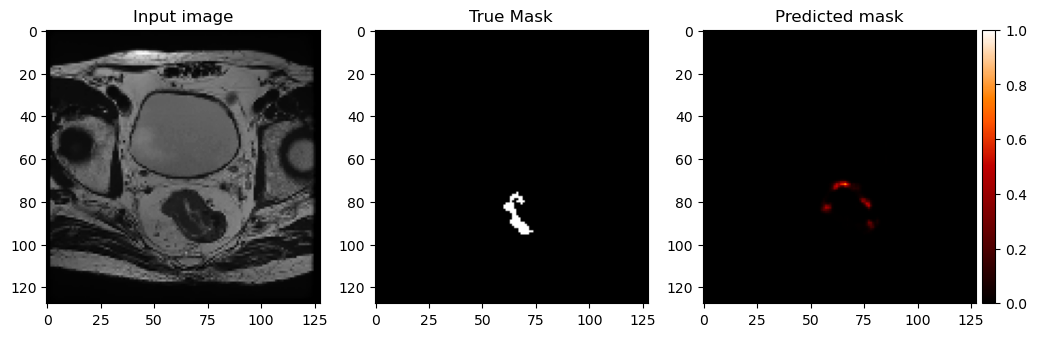

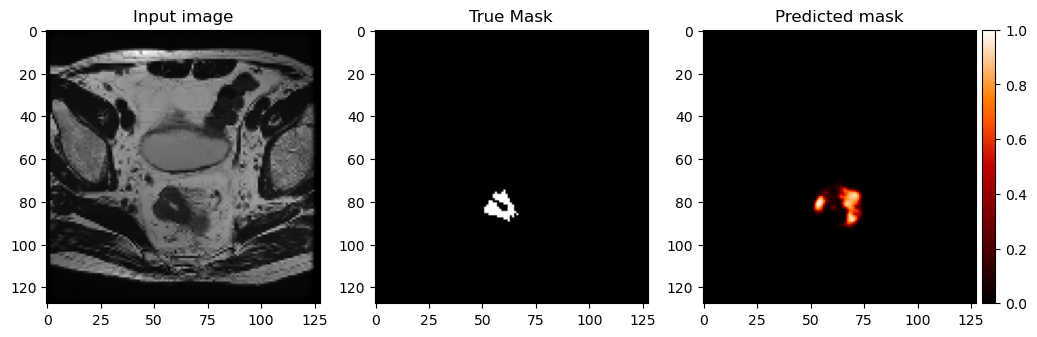

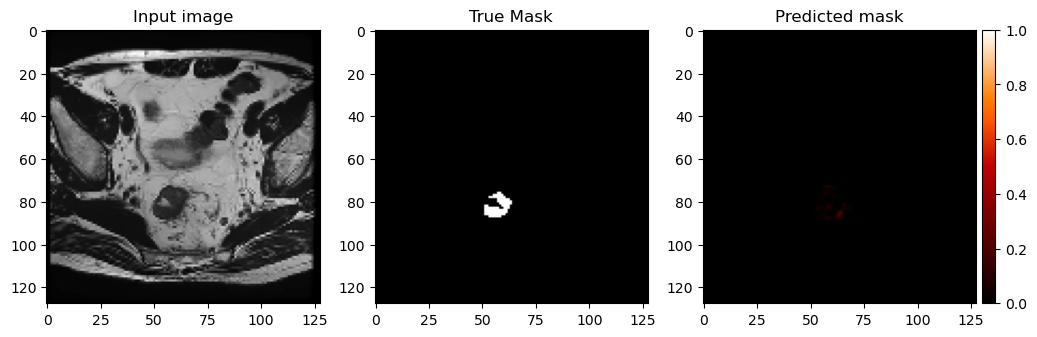

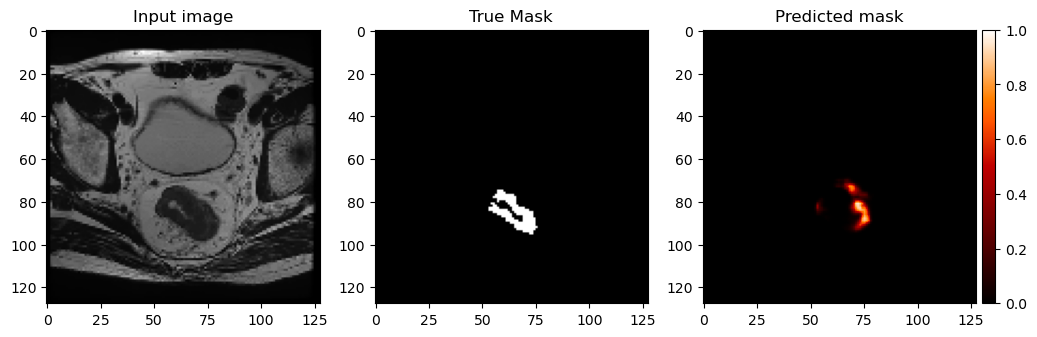

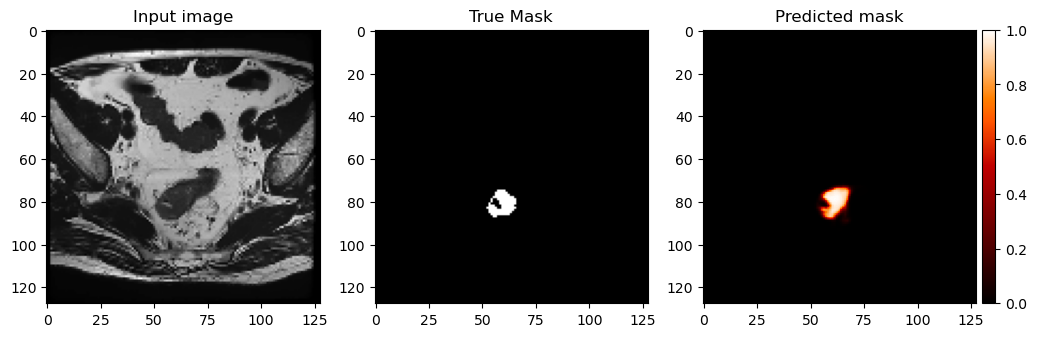

In [13]:

test_generator = create_segmentation_generator_test(data_dir_test_img, data_dir_test_mask, 1, IMG_SIZE, SEED)

show_prediction(test_generator, model, 15)